<head>
    <style>
        .md-typeset h2 {
            margin:0;
            }
        .md-typeset h3 {
            margin:0;
            }
        .jupyter-wrapper table.dataframe tr, .jupyter-wrapper table.dataframe th, .jupyter-wrapper table.dataframe td {
            text-align:left;
            }
        .jupyter-wrapper table.dataframe {
            table-layout: auto;
            }
    </style>
</head>

# Lab 1: An Empirical Analysis of Racial Differences in Police Use of Force

Here is the outline of this lab:

* download the stop-question-frisk dataset 
* clean the stop-question-frisk dataset
* download the census race dataset
* clean the census race dataset


## The stop-question-frisk dataset

Use the `python` [script](https://raw.githubusercontent.com/oceanumeric/oceanumeric.github.io/main/docs/math/causal/code/lab1.py) to download the dataset.

After downloading the dataset, please use the `R` [script](https://raw.githubusercontent.com/oceanumeric/oceanumeric.github.io/main/docs/math/causal/code/lab1.R) to clean the dataset.

Problems of the dataset:

1. potential misreporting by officers
2. data for stops only


In [8]:
# load packages
if (!require("pacman")) install.packages("pacman")
library(pacman)
p_load(tidyverse, RCurl, data.table, scico, gridExtra, naniar, 
                    scales, miceadds, here, pROC, ROCR, stargazer)

In [1]:
# load the dataset 
load(file = "./data/lab1/sqf_03_13.RData")

In [6]:
head(sqf_data)

year,pct,timestop,inout,typeofid,othpers,arstmade,sumissue,offunif,frisked,⋯,cs_furtv,cs_vcrim,cs_bulge,cs_other,ac_incid,ac_time,sex,race,age,addrpct
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
2003,70,03:00,O,V,Y,N,N,Y,Y,⋯,Y,N,N,Y,N,N,M,B,16,NA
2003,70,03:00,O,V,Y,N,N,Y,Y,⋯,Y,N,N,N,N,N,M,B,15,NA
2003,68,03:00,I,V,Y,N,N,Y,Y,⋯,Y,N,N,N,N,N,M,Q,39,NA
2003,48,16:00,I,R,Y,N,N,N,N,⋯,N,N,N,N,N,N,F,Q,20,NA
2003,48,03:35,O,P,N,N,N,Y,Y,⋯,N,N,N,N,N,N,M,B,19,NA
2003,9,11:40,O,P,N,N,N,Y,N,⋯,N,N,N,N,N,N,M,I,0,NA


The dimension of dataset is $4984393 \times 42$, we will focus on the analysis
of racial differences in police use of force. 

### Racial features

In [51]:
print(summary(factor(sqf_data$race)))

              A       B       I       P       Q       U       W       X       Z 
    164  152053 2581244   19675  305601 1215401   22366  492688    2137  193064 


The meaning of symbols:

* A - Asian
* B - Black
* W - White
* U - Unknown
* Z - other 
* Q - Hispanic 
* X - no clue what it means 

In [52]:
# race proportion
sqf_data %>%
    select(race) %>%
    group_by(race) %>%
    summarize(count = n()) %>%
    spread(race, count) %>%
    summarize(
        total=A+B+I+P+Q+U+W+X+Z, white=W/total, black=B/total,
        asian=A/total, hispanic=Q/total, other = (I+U+Z+X)/total
    ) %>%
    mutate(total=NULL) %>% round(2)

white,black,asian,hispanic,other
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1,0.52,0.03,0.24,0.05


In [37]:
summary(sqf_data$age)  # need to delete dubious values

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.00   19.00   24.00   28.64   34.00 9999.00     203 

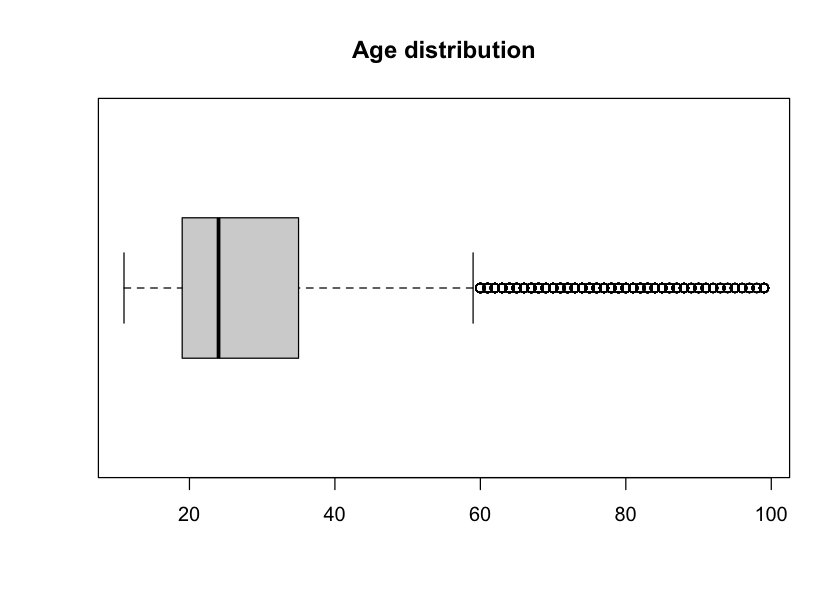

In [50]:
# age proportion
options(repr.plot.width=7, repr.plot.height=5)  # figsize
sqf_data %>%
    select(age) %>%
    filter(age>10 & age<100) %>%
    boxplot(
        main="Age distribution",
        horizontal = TRUE)

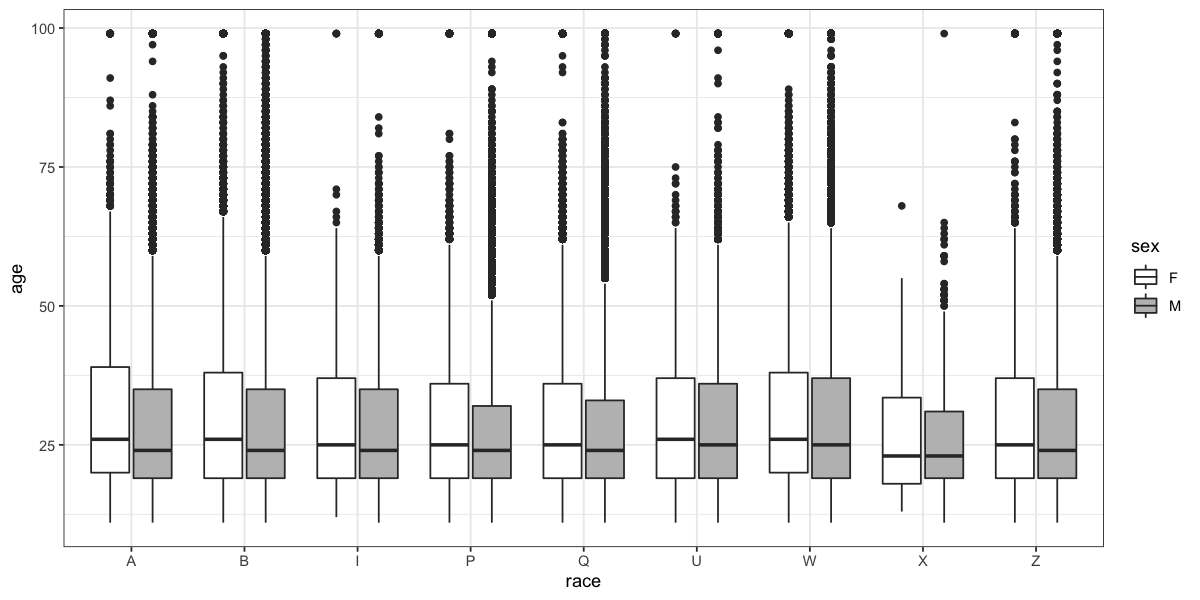

In [76]:
# age distribution for different race and age
options(repr.plot.width=10, repr.plot.height=5)  # figsize
sqf_data %>%
    select(race, age, sex) %>%
    filter(age>10 & age<100) %>%
    filter (sex != "Z") %>%  # drop unknown 
    ggplot(aes(x=race, y=age, fill=sex)) + geom_boxplot() + theme_bw() +
    scale_fill_manual(values=c("#FFFFFF", "grey"))

### Encounter characteristics 

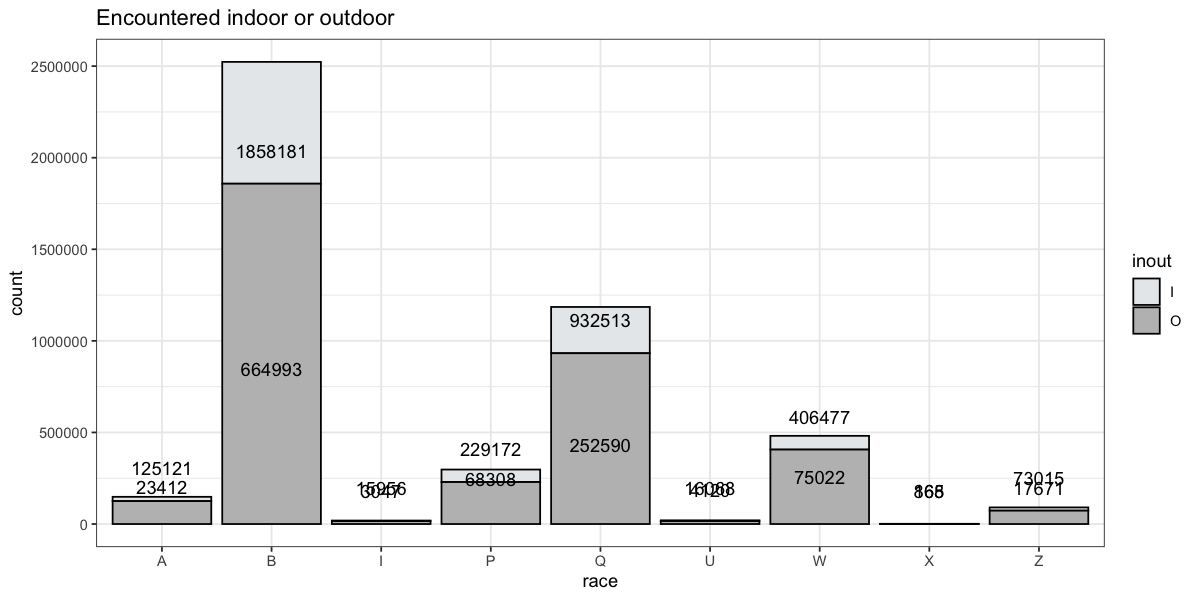

In [124]:
# indoor or outdoor
options(dplyr.summarise.inform = FALSE)
sqf_data %>%
    select(race, age, sex, inout) %>%
    filter(age>10 & age<100) %>%
    filter(sex != "Z") %>%  # drop unknown
    filter(inout != '') %>%  # drop empty string
    group_by(inout, race) %>%
    summarize(count=n()) %>%
    ggplot(aes(x=race, y=count, fill=inout)) + geom_col(color='black') +
    theme_bw() + scale_fill_manual(values=c("#e7eaed", "grey")) + 
    geom_text(aes(label=count), vjust=-2) + 
    labs(title="Encountered indoor or outdoor")

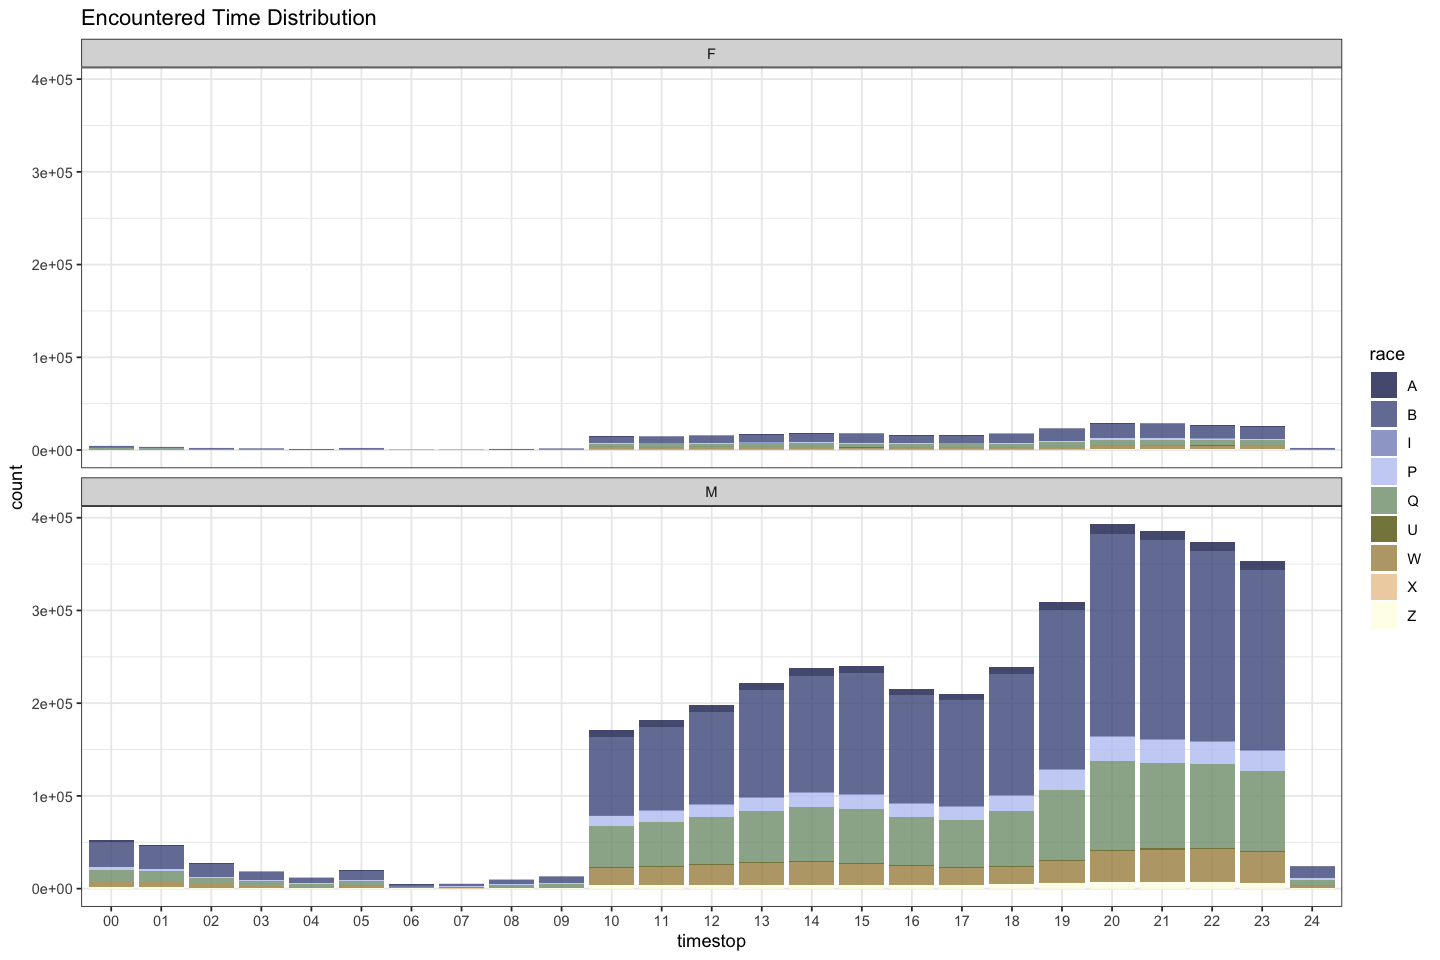

In [196]:
# time stop
options(repr.plot.width=12, repr.plot.height=8)  # figsize
sqf_data %>%
    select(race, age, sex, timestop) %>%
    filter(age>10 & age<100) %>%
    filter(sex != "Z") %>%  # drop unknown
    filter(timestop != "other") %>%
    drop_na(timestop) %>%
    mutate(timestop = as.numeric(substr(timestop, 1, 2))) %>%
    filter(timestop <= 24) %>%
    mutate(timestop = sprintf("%02d", timestop)) %>%
    group_by(timestop, race, sex) %>%
    summarize(count=n()) %>% 
    ggplot(aes(x=timestop, y=count, fill=race)) + geom_col(alpha=0.8) +
    facet_wrap(~sex, nrow=2) + theme_bw() + 
    scale_fill_manual(values=scico(9, palette = 'oleron')) + 
    labs(title="Encountered Time Distribution")

### Civilian behaviors 

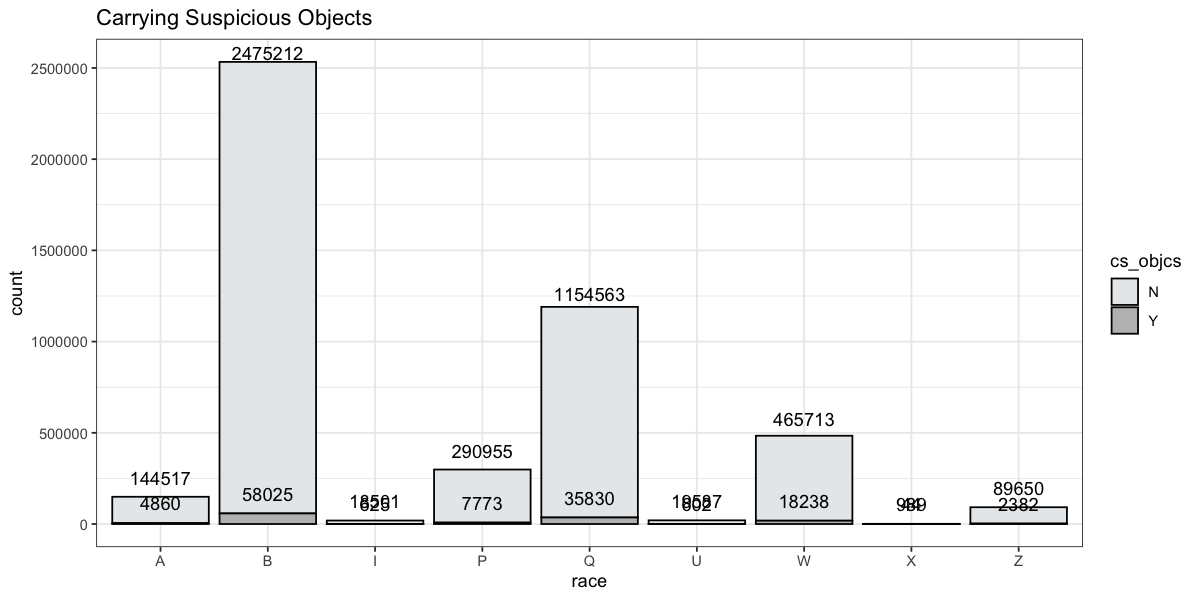

In [207]:
# Carrying Suspicious Objects
options(repr.plot.width=10, repr.plot.height=5)  # figsize
sqf_data %>%
    select(race, age, sex, cs_objcs) %>%
    filter(age>10 & age<100) %>%
    filter(sex != "Z") %>%  # drop unknown
    group_by(cs_objcs, race) %>%
    summarize(count=n()) %>%
    ggplot(aes(x=race, y=count, fill=cs_objcs)) + 
    geom_col(color='black') +
    theme_bw() + scale_fill_manual(values=c("#e7eaed", "grey")) + 
    geom_text(aes(label=count), vjust=-1) + 
    labs(title="Carrying Suspicious Objects")


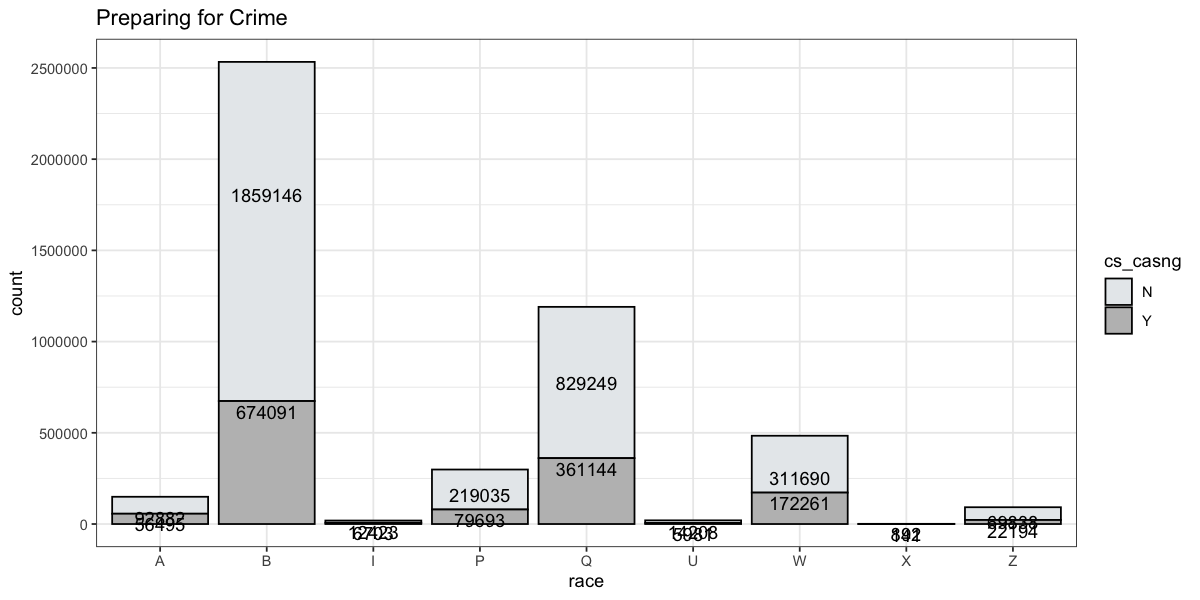

In [213]:
# Preparing for Crime
options(repr.plot.width=10, repr.plot.height=5)  # figsize
sqf_data %>%
    select(race, age, sex, cs_casng) %>%
    filter(age>10 & age<100) %>%
    filter(sex != "Z") %>%  # drop unknown
    group_by(cs_casng, race) %>%
    summarize(count=n()) %>%
    ggplot(aes(x=race, y=count, fill=cs_casng)) + 
    geom_col(color='black') +
    theme_bw() + scale_fill_manual(values=c("#e7eaed", "grey")) + 
    geom_text(aes(label=count), vjust=1.3) + 
    labs(title="Preparing for Crime")

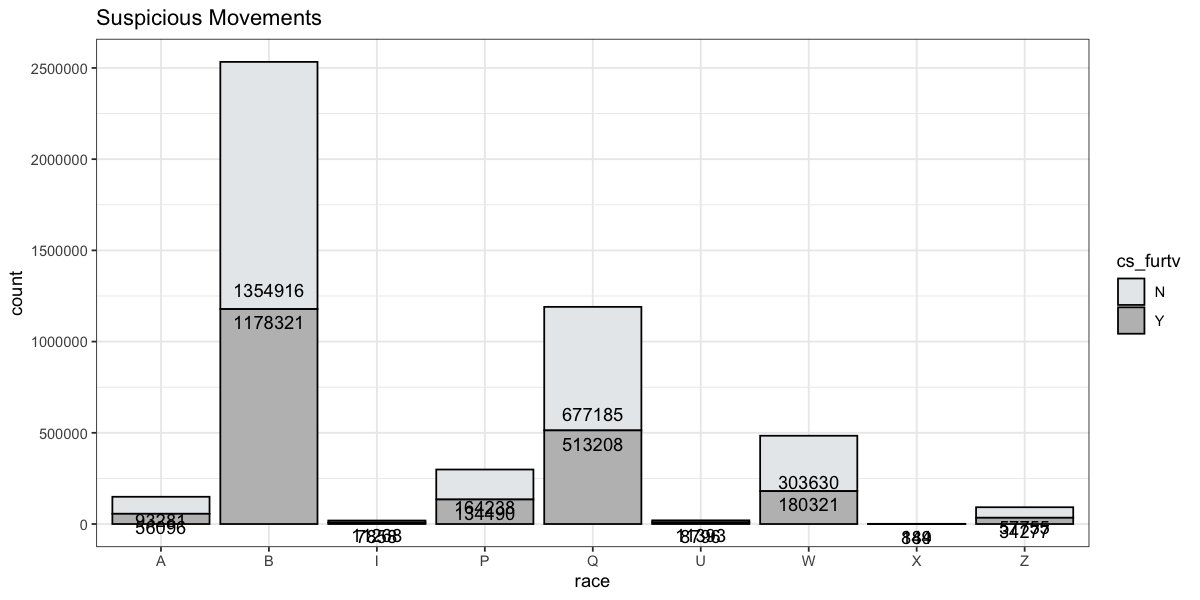

In [219]:
# Suspicious Movements
options(repr.plot.width=10, repr.plot.height=5)  # figsize
sqf_data %>%
    select(race, age, sex, cs_furtv) %>%
    filter(age>10 & age<100) %>%
    filter(sex != "Z") %>%  # drop unknown
    group_by(cs_furtv, race) %>%
    summarize(count=n()) %>%
    ggplot(aes(x=race, y=count, fill=cs_furtv)) + 
    geom_col(color='black') +
    theme_bw() + scale_fill_manual(values=c("#e7eaed", "grey")) + 
    geom_text(aes(label=count), vjust=1.5) + 
    labs(title="Suspicious Movements")

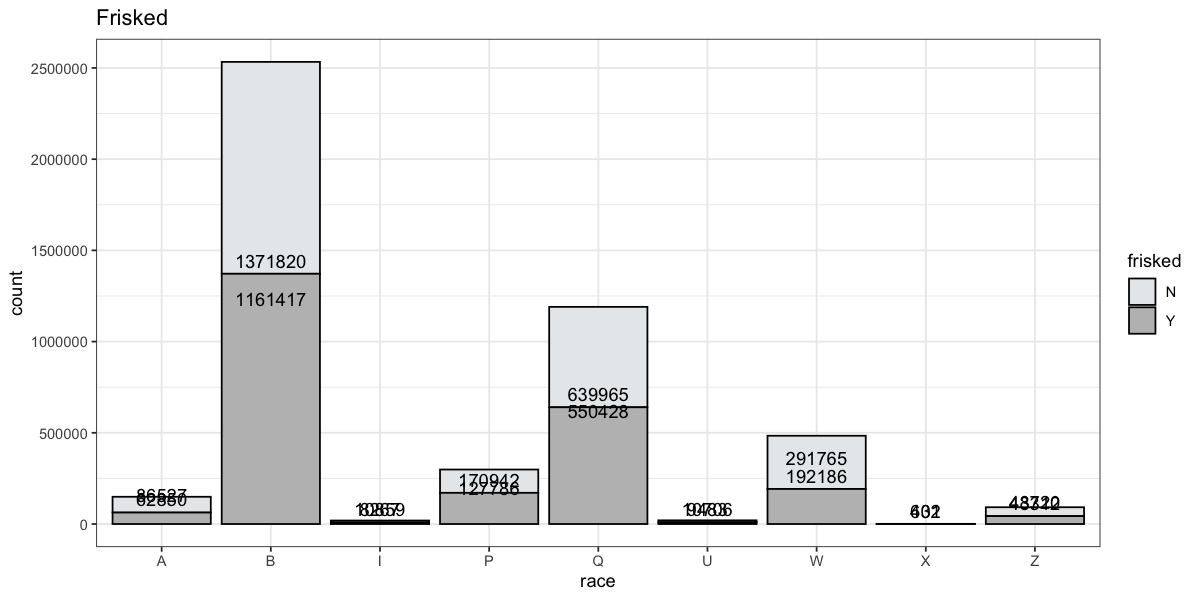

In [224]:
# Frisked
sqf_data %>%
    select(race, age, sex, frisked) %>%
    filter(age>10 & age<100) %>%
    filter(sex != "Z") %>%  # drop unknown
    group_by(frisked, race) %>%
    summarize(count=n()) %>%
    ggplot(aes(x=race, y=count, fill=frisked)) + 
    geom_col(color='black') +
    theme_bw() + scale_fill_manual(values=c("#e7eaed", "grey")) + 
    geom_text(aes(label=count), vjust=-0.5) + 
    labs(title="Frisked")

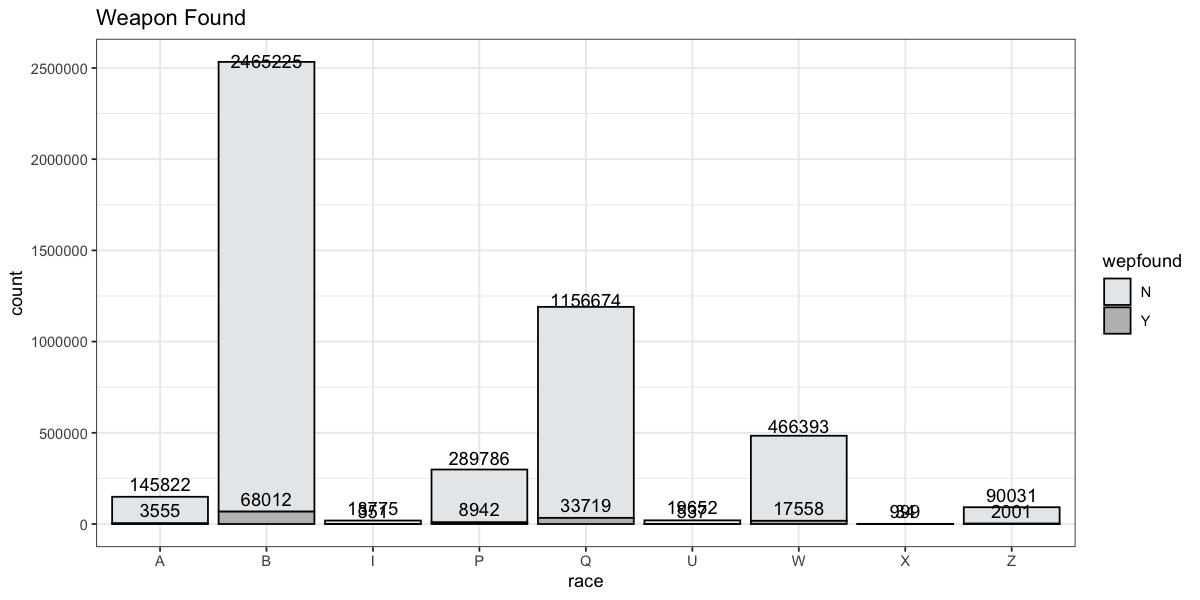

In [232]:
# weapon found 
sqf_data %>%
    mutate(wepfound = paste(contrabn,asltweap,pistol,riflshot,
    knifcuti,machgun,othrweap, sep = "")) %>%
    mutate(wepfound = if_else(grepl("Y",wepfound), "Y", "N"))  %>%
    select(race, age, sex, wepfound) %>%
    filter(age>10 & age<100) %>%
    filter(sex != "Z") %>%  # drop unknown
    group_by(wepfound, race) %>%
    summarize(count=n()) %>%
    ggplot(aes(x=race, y=count, fill=wepfound)) + 
    geom_col(color='black') +
    theme_bw() + scale_fill_manual(values=c("#e7eaed", "grey")) + 
    geom_text(aes(label=count), vjust=-0.5) + 
    labs(title="Weapon Found")

### Use of force

<img src="/math/causal/images/uof.png">

In this section, we will investigate whether black people are
discriminated when it comes to the police use of force. 

In [ ]:
# filter the dataset 
sqf_data %>%
    # only focus on black, white, and hispanic 
    filter(race != "U",race!="X", race != "Z", race != "A",
    race != "I", race != "P", race != " ", !is.na(race))%>% 
    mutate(pf_spray_baton = paste(pf_pepsp,
                                    pf_baton,sep = "")) %>%
    mutate(pf_spray_baton = ifelse(grepl("Y",pf_spray_baton), 
                                                "Y", "N")) %>%
    filter(age>10 & age<100) %>%
    filter(sex != "Z") -> temp

In [386]:
# there are two ways to calculate the proportion of the use of force
# for each race: 1) do it one force by one force; 2) use reshape magic
# method 1 
temp %>% 
    select(race, sex, pf_hands) %>% 
    group_by(race, sex, pf_hands) %>% 
    summarize(freq=n()) %>%
    spread(pf_hands, freq) %>% 
    summarize(total=N+Y, hands=Y/total) %>% 
    mutate(total=NULL) -> foo 

# initialize the dataframe
force_df <- NULL
force_df <- rbind(force_df, foo)

head(force_df)

race,sex,hands
<chr>,<chr>,<dbl>
B,F,0.09792980
B,M,0.19795418
Q,F,0.09457339
Q,M,0.20439862
W,F,0.06821081
W,M,0.13688098


In [387]:
# push to the wall
temp %>%
    select(race, sex, pf_wall) %>%
    group_by(race, sex, pf_wall) %>% 
    summarize(freq=n()) %>%
    spread(pf_wall, freq) %>% 
    summarize(total=N+Y, push_to_wall=Y/total) %>% 
    mutate(total=NULL) -> foo 
force_df <- full_join(force_df, foo, by=c('race', 'sex'))
head(force_df)

race,sex,hands,push_to_wall
<chr>,<chr>,<dbl>,<dbl>
B,F,0.09792980,0.01696462
B,M,0.19795418,0.03009473
Q,F,0.09457339,0.02002396
Q,M,0.20439862,0.03565673
W,F,0.06821081,0.01609605
W,M,0.13688098,0.02831140


In [390]:
# you can see it takes time to do one force by one force
# here is the magic 
temp %>%
    select(race, sex, pf_hands, pf_hcuff, pf_wall, pf_drwep,
    pf_ptwep, pf_spray_baton) %>%
    gather(force, value, (pf_hands:pf_spray_baton )) %>% 
    group_by(race, sex, force, value) %>%
    summarize(freq=n()) %>%
    spread(value, freq) %>% 
    mutate(share=Y/(Y+N)) -> force_df2

head(force_df2)
    

race,sex,force,N,Y,share
<chr>,<chr>,<chr>,<int>,<int>,<dbl>
B,F,pf_drwep,173789,397,0.0022791728
B,F,pf_hands,157128,17058,0.0979297992
B,F,pf_hcuff,166238,7948,0.0456293847
B,F,pf_ptwep,173623,563,0.0032321771
B,F,pf_spray_baton,174124,62,0.0003559414
B,F,pf_wall,171231,2955,0.0169646240


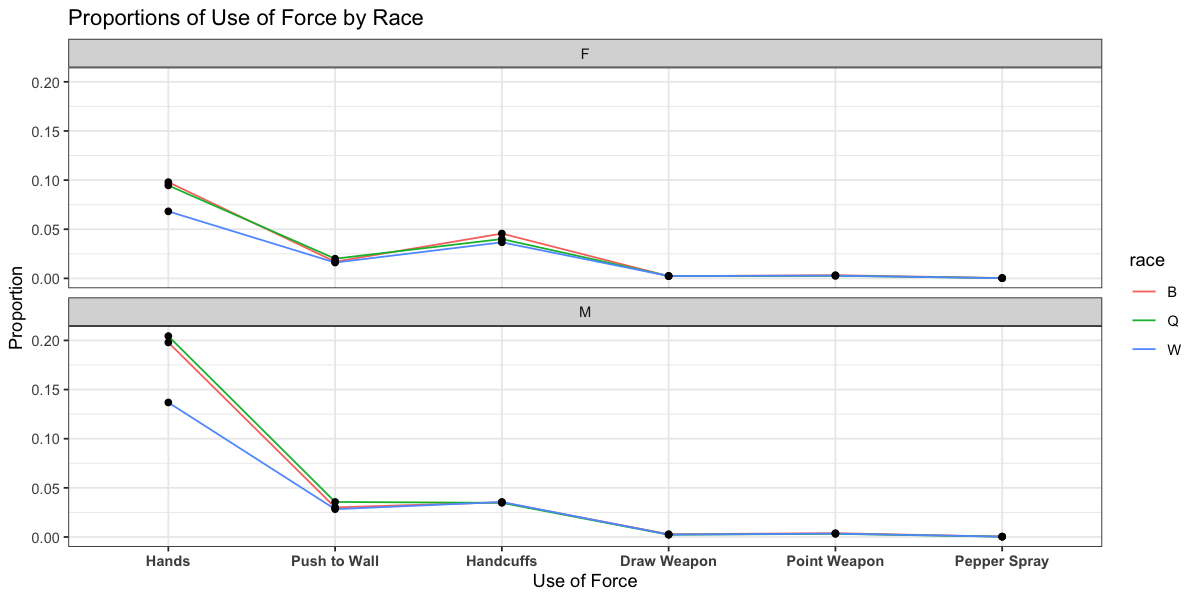

In [396]:
force_df2 %>%
    mutate(force=factor(force, levels=c('pf_hands', 'pf_wall',
                            'pf_hcuff', 'pf_drwep', 'pf_ptwep',
                            'pf_spray_baton'))) %>%
    ggplot(aes(x=force, y=share, group=race)) + 
    geom_line(aes(color=race))+ geom_point() + 
    facet_wrap(~sex, nrow=2) + 
    labs(title="Proportions of Use of Force by Race", x="Use of Force",
            y='Proportion') + theme_bw() +
            scale_x_discrete(labels=c('Hands', 'Push to Wall',
                                    'Handcuffs', 'Draw Weapon',
                                    'Point Weapon', 'Pepper Spray')) +
            theme(axis.text.x = element_text(face='bold'))

## Logistic Regression Modeling 

We will estimate logistic regressions of the following form:

$\ln\big ( \frac{Pr(\text{Force}_{i, t} = 1)}{1-Pr(\text{Force}_{i, p}=1)} \big ) = \alpha \cdot \text{Race}_i  + \beta X_{i,t} + \epsilon_{i,t}$

The covariate matrix $X_{i,t}$ is a matrix of control variables, which is
illustrated in the following figure. 

<img src="/math/causal/images/regmodel1.png">

please use the `R` [script](https://raw.githubusercontent.com/oceanumeric/oceanumeric.github.io/main/docs/math/causal/code/lab1.R) to create the dataset for regression.

In [3]:
# load the dataset 
load(file = "./data/lab1/sqf_reg_data.RData")

In [5]:
print(summary(sqf_reg_data$race))

   White    Black Hispanic    Asian    Other        P 
  412073  2207981  1029175   128283   123461   262668 


In [6]:
# model with no control: race as the only predictor 
# and Use of force as the outcome
model_no_control <- glm(any_force_used ~ race,
                      data = sqf_reg_data,
                      family = "binomial")

In [9]:
# use white as the benchmark
sqf_reg_data %>%
    filter(race == 'White') %>% 
    summarize(mean=round(mean(any_force_used==1), 3)) -> white_mean
# create a table for with interpretable coefficients
no_control <- data.frame(Model= "No Control", 
                        WhiteMean = as.character(white_mean$mean),
                         Black = exp(coef(model_no_control))[2], 
                         Hispanic = exp(coef(model_no_control))[3],
                         Asian = exp(coef(model_no_control))[4],
                         P = exp(coef(model_no_control))[6],
                         Others = exp(coef(model_no_control))[5])
rownames(no_control) <- NULL
no_control

Model,WhiteMean,Black,Hispanic,Asian,P,Others
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No Control,0.158,1.466073,1.575896,1.082387,1.741726,1.340862


In [ ]:
# predict(model_no_control, sqf_reg_data, type = "response")
preds_no_control <- predict(model_no_control, sqf_reg_data,
                                                type='response')

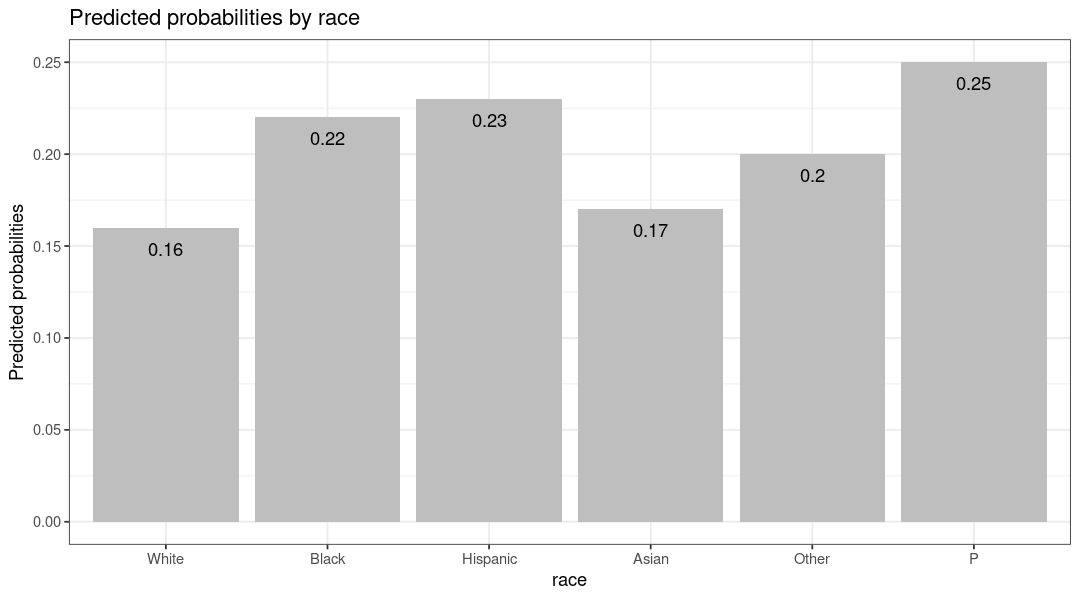

In [17]:
options(repr.plot.width=9, repr.plot.height=5)  # figsize
sqf_reg_data %>%
    select(race) %>%
    mutate(pred=preds_no_control) %>%
    group_by(race) %>%
    summarize(pred=round(mean(pred), 2)) %>%
    ggplot(aes(x=race, y=pred)) + geom_col(fill='#BEBEBE') + 
    theme_bw() + geom_text(aes(label=pred), vjust=2) +
    labs(title="Predicted probabilities by race",
            y='Predicted probabilities')

The above figure shows that black people are $37.5\%$ more like to 
experience any use of force relative to white mean of $15\%$.

In [18]:
(0.22-0.16)/0.16

[1] 0.375

In [4]:
# full controls, it takes some time to run 
model_full_control <- glm(any_force_used ~ race + sex + age + I(age^2) + 
                            inout + daytime + ac_incid + ac_time +
                            offunif + typeofid + othpers + cs_bulge + 
                            cs_cloth + cs_casng + cs_lkout +
                            cs_descr + cs_drgtr + cs_furtv + cs_vcrim +
                            cs_objcs + cs_other + wepnfnd + pct + year,
                          data = sqf_reg_data,
                          family = "binomial")

In [37]:
stargazer(model_no_control, model_full_control, type='text',
            title = "Logistic regression of use of any force",
            column.labels = c('No controls', 'Full controls'),
            omit=c('cs', 'pct', 'year', 'type'),
            add.lines=list(c('Other controls', 'No', 'Yes')),
            single.row=TRUE)


Logistic regression of use of any force
                           Dependent variable:          
                  --------------------------------------
                              any_force_used            
                     No controls       Full controls    
                         (1)                (2)         
--------------------------------------------------------
raceBlack         0.383*** (0.005)    0.165*** (0.005)  
raceHispanic      0.455*** (0.005)    0.129*** (0.006)  
raceAsian         0.079*** (0.009)     -0.014 (0.009)   
raceOther         0.293*** (0.008)    0.064*** (0.010)  
raceP             0.555*** (0.006)    0.181*** (0.007)  
sexM                                  0.499*** (0.006)  
sexZ                                  0.471*** (0.013)  
age                                  -0.007*** (0.0001) 
I(age2)                             0.00001*** (0.00000)
inout1                               -0.156*** (0.003)  
daytime1                             -0.152*** 

In [41]:
# create a table for with interpretable coefficients for full controls 
full_control <- data.frame(Model= "Full Control", 
                        WhiteMean = as.character(white_mean$mean),
                         Black = exp(coef(model_full_control))[2], 
                         Hispanic = exp(coef(model_full_control))[3],
                         Asian = exp(coef(model_full_control))[4],
                         P = exp(coef(model_full_control))[6],
                         Others = exp(coef(model_full_control))[5])
rownames(full_control) <- NULL
bind_rows(no_control, full_control)

Model,WhiteMean,Black,Hispanic,Asian,P,Others
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No Control,0.158,1.466073,1.575896,1.0823870,1.741726,1.340862
Full Control,0.158,1.179428,1.137263,0.9858007,1.197828,1.065685


In [5]:
# predict(model_no_control, sqf_reg_data, type = "response")
preds_full_control <- predict(model_full_control, sqf_reg_data,
                                                type='response')

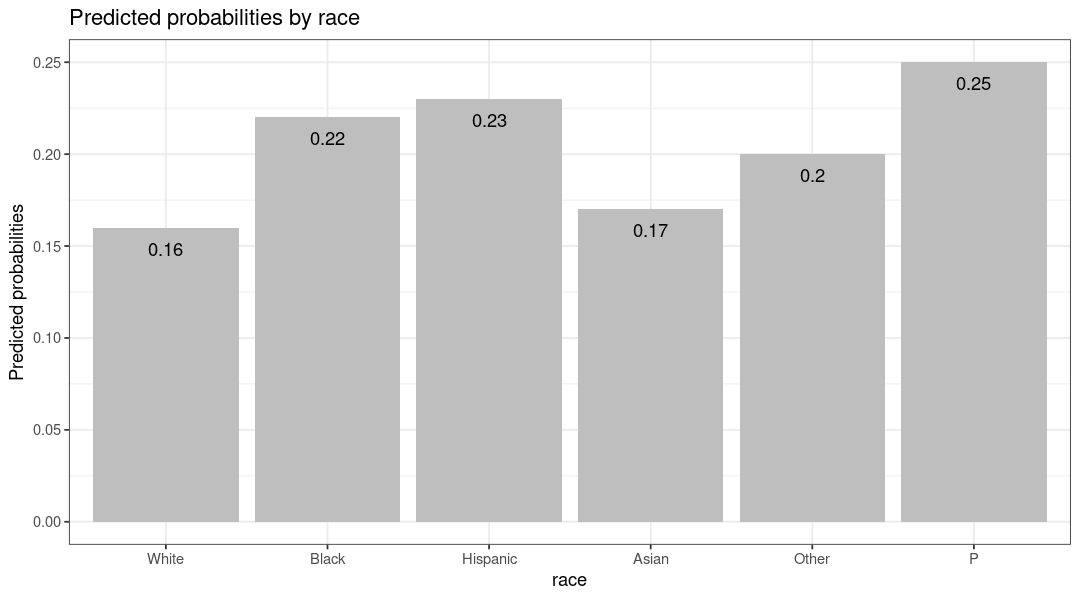

In [11]:
options(repr.plot.width=9, repr.plot.height=5)  # figsize
sqf_reg_data %>%
    select(race) %>%
    mutate(pred=preds_full_control) %>%
    drop_na() %>% 
    group_by(race) %>%
    summarize(pred=round(mean(pred), 2)) %>%
    ggplot(aes(x=race, y=pred)) + geom_col(fill='#BEBEBE') + 
    theme_bw() + geom_text(aes(label=pred), vjust=2) +
    labs(title="Predicted probabilities by race (full controls)",
            y='Predicted probabilities')

By running two different regressions, we can see that adding more control
variables does not change the predictions that much. 

In [18]:
sqf_reg_data %>%
    select(race, any_force_used) %>%
    mutate(pred_prob=preds_full_control) %>%
    drop_na() %>% 
    group_by(race) %>%
    summarize(count=n(), force_likelihood=sum(any_force_used==1),
                    pred_prob=round(mean(pred_prob), 2)) %>%
    mutate(force_prob = round(force_likelihood/count, 2))

race,count,force_likelihood,pred_prob,force_prob
<fct>,<int>,<int>,<dbl>,<dbl>
White,412052,65206,0.16,0.16
Black,2207814,477044,0.22,0.22
Hispanic,1029118,235211,0.23,0.23
Asian,128280,21690,0.17,0.17
Other,123440,24850,0.20,0.20
P,262662,64791,0.25,0.25


From the above figure, we can see that __our model just memorized
the whole dataset__. 

## Takeaway

> Big data does not mean big insights 